# 00. Basic Cosmology (pyccl)
Sweep core cosmological parameters and inspect background observables.


In [41]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
import numpy as np

try:
    import pyccl as ccl
except Exception as e:
    raise RuntimeError('Install pyccl first: pip install pyccl') from e

print('pyccl version:', getattr(ccl, '__version__', 'unknown'))

SETTINGS = {
    'output_dir': Path('/home/z/Zekang.Zhang/cosmo_playground/outputs/pyccl_basic_cosmology'),
    'n_points': 7,
    'include_regex': [],
    'exclude_regex': [],
    'ell_min': 20,
    'ell_max': 3000,
    'n_ell': 120,
    'z_min': 0.001,
    'z_max': 3.0,
    'n_z': 600,
    'alpha': 2.0,
    'beta': 1.5,
    'z0': 0.5,
    'source_bins': [(0.20, 0.55), (0.55, 0.85), (0.85, 1.30), (1.30, 2.00)],
    'lens_bins': [(0.20, 0.45), (0.45, 0.70), (0.70, 0.95), (0.95, 1.20)],
    'transfer_function': 'eisenstein_hu',
    'parameters': {
        'omega_m': (0.24, 0.31, 0.40),
        'omega_c': (0.20, 0.26, 0.34),
        'omega_b': (0.040, 0.049, 0.060),
        'h': (0.60, 0.68, 0.76),
        'n_s': (0.92, 0.965, 1.02),
        'sigma8': (0.70, 0.82, 0.94),
        'w0': (-1.2, -1.0, -0.8),
        'wa': (-0.6, 0.0, 0.6),
        'm_nu': (0.0, 0.06, 0.30),
        'Omega_k': (-0.02, 0.0, 0.02),
        'Neff': (3.046, 3.046, 3.7),
        'a_ia': (-1.0, 0.5, 3.0),
        'eta_ia': (-2.0, 0.0, 2.0),
        'b_lens_1': (0.8, 1.2, 2.2),
        'b_lens_2': (0.8, 1.3, 2.3),
        'b_lens_3': (0.8, 1.4, 2.4),
        'b_lens_4': (0.8, 1.5, 2.5),
        'm_source_1': (-0.03, 0.00, 0.03),
        'm_source_2': (-0.03, 0.00, 0.03),
        'm_source_3': (-0.03, 0.00, 0.03),
        'm_source_4': (-0.03, 0.00, 0.03),
        'dz_source_1': (-0.08, 0.00, 0.08),
        'dz_source_2': (-0.08, 0.00, 0.08),
        'dz_source_3': (-0.08, 0.00, 0.08),
        'dz_source_4': (-0.08, 0.00, 0.08),
        'dz_lens_1': (-0.05, 0.00, 0.05),
        'dz_lens_2': (-0.05, 0.00, 0.05),
        'dz_lens_3': (-0.05, 0.00, 0.05),
        'dz_lens_4': (-0.05, 0.00, 0.05),
    }
}


pyccl version: 3.2.1


In [42]:
def fiducial_params(settings):
    return {k: float(v[1]) for k, v in settings['parameters'].items()}


def filter_params(settings, names):
    out = []
    for n in names:
        if n not in settings['parameters']:
            continue
        if settings['include_regex'] and not any(re.search(p, n) for p in settings['include_regex']):
            continue
        if settings['exclude_regex'] and any(re.search(p, n) for p in settings['exclude_regex']):
            continue
        out.append(n)
    return out


def make_grids(settings):
    ell = np.unique(np.geomspace(settings['ell_min'], settings['ell_max'], settings['n_ell']).astype(int))
    z = np.linspace(settings['z_min'], settings['z_max'], settings['n_z'])
    return ell, z


def smail_nz(z, alpha, beta, z0):
    nz = z**alpha * np.exp(-(z / z0) ** beta)
    nz[z <= 0] = 0.0
    area = np.trapezoid(nz, z)
    return nz / area if area > 0 else nz


def top_hat_bin(z, zmin, zmax):
    m = np.zeros_like(z)
    m[(z >= zmin) & (z < zmax)] = 1.0
    return m


def shift_nz(z, nz, dz):
    out = np.interp(z - dz, z, nz, left=0.0, right=0.0)
    area = np.trapezoid(out, z)
    return out / area if area > 0 else out


def build_tomo_nz(z, bins, base_nz, dz_prefix, params):
    out = []
    for i, (zmin, zmax) in enumerate(bins, start=1):
        nz = base_nz * top_hat_bin(z, zmin, zmax)
        out.append(shift_nz(z, nz, float(params.get(f'{dz_prefix}_{i}', 0.0))))
    return out


def ia_bias_curve(z, params, pivot_z=0.62):
    return float(params.get('a_ia', 0.0)) * ((1.0 + z)/(1.0 + pivot_z))**float(params.get('eta_ia', 0.0))


def build_cosmology(params, settings):
    omega_b = float(params['omega_b'])
    if 'omega_m' in params:
        omega_c = float(params['omega_m']) - omega_b
    else:
        omega_c = float(params['omega_c'])

    if omega_c <= 0:
        raise ValueError(f'Unphysical Omega_c={omega_c:.4g}; check omega_m and omega_b ranges.')

    kwargs = dict(
        Omega_c=omega_c,
        Omega_b=omega_b,
        h=float(params['h']),
        n_s=float(params['n_s']),
        sigma8=float(params['sigma8']),
        w0=float(params.get('w0', -1.0)),
        wa=float(params.get('wa', 0.0)),
        transfer_function=settings.get('transfer_function', 'eisenstein_hu'),
    )

    # Optional available parameters (used when present in SETTINGS['parameters']).
    if 'm_nu' in params:
        kwargs['m_nu'] = float(params['m_nu'])
    if 'Omega_k' in params:
        kwargs['Omega_k'] = float(params['Omega_k'])
    if 'Neff' in params:
        kwargs['Neff'] = float(params['Neff'])

    return ccl.Cosmology(**kwargs)


def build_tracers(cosmo, z, src_nz, lens_nz, params):
    ia = ia_bias_curve(z, params)
    src = [ccl.WeakLensingTracer(cosmo, dndz=(z, nz), ia_bias=(z, ia)) for nz in src_nz]
    lens = []
    for i, nz in enumerate(lens_nz, start=1):
        b = np.full_like(z, float(params.get(f'b_lens_{i}', 1.5)))
        lens.append(ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz), bias=(z, b)))
    return src, lens


def compute_hmf_fixed(cosmo, m, a=1.0):
    # Locked to the known working backend in this environment.
    mf = ccl.halos.MassFuncTinker08()
    y = mf(cosmo, m, a)
    y = np.asarray(y, dtype=float)
    if y.shape != np.asarray(m).shape:
        raise ValueError(f'Unexpected HMF shape: got {y.shape}, expected {np.asarray(m).shape}')
    return y


In [43]:
PARAMS_ALL = filter_params(SETTINGS, sorted(SETTINGS['parameters'].keys()))
# Avoid redundant sweep: omega_c is derived from omega_m when omega_m is present.
if 'omega_m' in PARAMS_ALL and 'omega_c' in PARAMS_ALL:
    PARAMS_ALL.remove('omega_c')
if not PARAMS_ALL:
    raise ValueError('No parameters selected after include/exclude filters.')

PHYS_GROUPS = {
    'expansion_geometry': ['omega_m', 'omega_b', 'h', 'Omega_k', 'w0', 'wa'],
    'growth_primordial': ['sigma8', 'n_s', 'm_nu', 'Neff'],
}

assigned = set()
GROUPED_PARAMS = {}
for g, names in PHYS_GROUPS.items():
    keep = [p for p in names if p in PARAMS_ALL]
    if keep:
        GROUPED_PARAMS[g] = keep
        assigned.update(keep)
leftover = [p for p in PARAMS_ALL if p not in assigned]

print('Parameter groups:')
for g, names in GROUPED_PARAMS.items():
    print(f'  {g}: {len(names)} params')
    print('   ->', names)
if leftover:
    print('Excluded (not physically relevant for this notebook):', leftover)

ell, z = make_grids(SETTINGS)
params0 = fiducial_params(SETTINGS)
cosmo0 = build_cosmology(params0, SETTINGS)


def run_group(gname):
    plist = GROUPED_PARAMS.get(gname, [])
    if not plist:
        print(f'skip group: {gname} (no params)')
        return

    print(f'\n=== Group: {gname} ({len(plist)} params) ===')

    m_hmf = np.geomspace(1e11, 1e15, 120)

    results = {}
    for pname in plist:
        lo, _, hi = SETTINGS['parameters'][pname]
        vals = np.linspace(lo, hi, SETTINGS['n_points'])

        curves_distance, curves_growth = [], []
        curves_transfer, curves_pk_lin, curves_pk_nl, curves_hmf = [], [], [], []

        for val in vals:
            p = dict(params0)
            p[pname] = float(val)
            try:
                cosmo = build_cosmology(p, SETTINGS)
            except ValueError as e:
                print(f'[skip] {pname}={val:.4g}: {e}')
                k = np.geomspace(1e-3, 10.0, 220)
                m = np.geomspace(1e11, 1e15, 120)
                nan_z = np.full_like(z, np.nan, dtype=float)
                nan_k = np.full_like(k, np.nan, dtype=float)
                nan_m = np.full_like(m, np.nan, dtype=float)
                curves_distance.append((z, nan_z))
                curves_growth.append((z, nan_z.copy()))
                curves_transfer.append((k, nan_k))
                curves_pk_lin.append((k, nan_k.copy()))
                curves_pk_nl.append((k, nan_k.copy()))
                curves_hmf.append((m, nan_m))
                continue

            a = 1.0 / (1.0 + z)
            chi = ccl.comoving_radial_distance(cosmo, a)
            growth = ccl.growth_factor(cosmo, a)

            k = np.geomspace(1e-3, 10.0, 220)
            pk_lin = ccl.linear_matter_power(cosmo, k, a=1.0)
            pk_nl = ccl.nonlin_matter_power(cosmo, k, a=1.0)
            t_eff = np.sqrt(np.maximum(pk_lin, 1e-60) / (k ** float(p['n_s'])))
            t_eff /= t_eff[0]

            curves_distance.append((z, chi))
            curves_growth.append((z, growth))
            curves_transfer.append((k, t_eff))
            curves_pk_lin.append((k, pk_lin))
            curves_pk_nl.append((k, pk_nl))

            m = m_hmf
            try:
                hmf_y = compute_hmf_fixed(cosmo, m, a=1.0)
            except Exception as e:
                print(f'[hmf warn] fixed backend failed at {pname}={val:.4g}: {e}')
                hmf_y = np.full_like(m, np.nan, dtype=float)
            curves_hmf.append((m, hmf_y))

        results[pname] = {
            'vals': vals,
            'distance': curves_distance,
            'growth': curves_growth,
            'transfer': curves_transfer,
            'pk_lin': curves_pk_lin,
            'pk_nl': curves_pk_nl,
            'hmf': curves_hmf,
        }

    def plot_quantity_group(quantity_key, title_prefix, xlab, ylab, logx=False, logy=False):
        n = len(plist)
        ncols = 3
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(5.0 * ncols, 3.8 * nrows), squeeze=False)
        axes = axes.ravel()

        for ax in axes[n:]:
            ax.axis('off')

        for ax, pname in zip(axes, plist):
            vals = results[pname]['vals']
            curves = results[pname][quantity_key]
            cmap = plt.get_cmap('viridis')
            colors = cmap(np.linspace(0, 1, len(vals)))

            valid_any = False
            x_has_pos = False
            y_has_pos = False
            for color, (xx, yy) in zip(colors, curves):
                xx = np.asarray(xx)
                yy = np.asarray(yy)
                m = np.isfinite(xx) & np.isfinite(yy)
                if not np.any(m):
                    continue
                valid_any = True
                x_plot = xx[m]
                y_plot = yy[m]
                ax.plot(x_plot, y_plot, color=color, lw=1.3)
                x_has_pos = x_has_pos or np.any(x_plot > 0)
                y_has_pos = y_has_pos or np.any(y_plot > 0)

            if logx and x_has_pos:
                ax.set_xscale('log')
            if logy and y_has_pos:
                ax.set_yscale('log')

            ax.set_title(pname)
            ax.set_xlabel(xlab)
            ax.set_ylabel(ylab)
            ax.grid(alpha=0.2)

            if not valid_any:
                ax.text(0.5, 0.5, 'No valid curves', transform=ax.transAxes,
                        ha='center', va='center', fontsize=9)

            sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=float(vals.min()), vmax=float(vals.max())))
            fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.02, label=pname)

        fig.suptitle(f'{title_prefix} | group: {gname}', y=1.02)
        fig.tight_layout()
        plt.show()

    plot_quantity_group('distance', 'Comoving distance (panels by parameter)', 'z', 'chi(z) [Mpc]')
    plot_quantity_group('growth', 'Growth D(z) (panels by parameter)', 'z', 'D(z)')
    plot_quantity_group('transfer', 'Transfer-shape proxy from P_lin (panels by parameter)', 'k [1/Mpc]', 'T_proxy(k)', logx=True)
    plot_quantity_group('pk_lin', 'Linear P(k) (panels by parameter)', 'k [1/Mpc]', 'P_lin(k)', logx=True, logy=True)
    plot_quantity_group('pk_nl', 'Nonlinear P(k) (panels by parameter)', 'k [1/Mpc]', 'P_nl(k)', logx=True, logy=True)
    plot_quantity_group('hmf', 'Halo mass function (panels by parameter)', 'M [Msun]', 'dn/dlog10M', logx=True, logy=True)


Parameter groups:
  expansion_geometry: 6 params
   -> ['omega_m', 'omega_b', 'h', 'Omega_k', 'w0', 'wa']
  growth_primordial: 4 params
   -> ['sigma8', 'n_s', 'm_nu', 'Neff']
Excluded (not physically relevant for this notebook): ['a_ia', 'b_lens_1', 'b_lens_2', 'b_lens_3', 'b_lens_4', 'dz_lens_1', 'dz_lens_2', 'dz_lens_3', 'dz_lens_4', 'dz_source_1', 'dz_source_2', 'dz_source_3', 'dz_source_4', 'eta_ia', 'm_source_1', 'm_source_2', 'm_source_3', 'm_source_4']


## Group: `expansion_geometry`



=== Group: expansion_geometry (6 params) ===


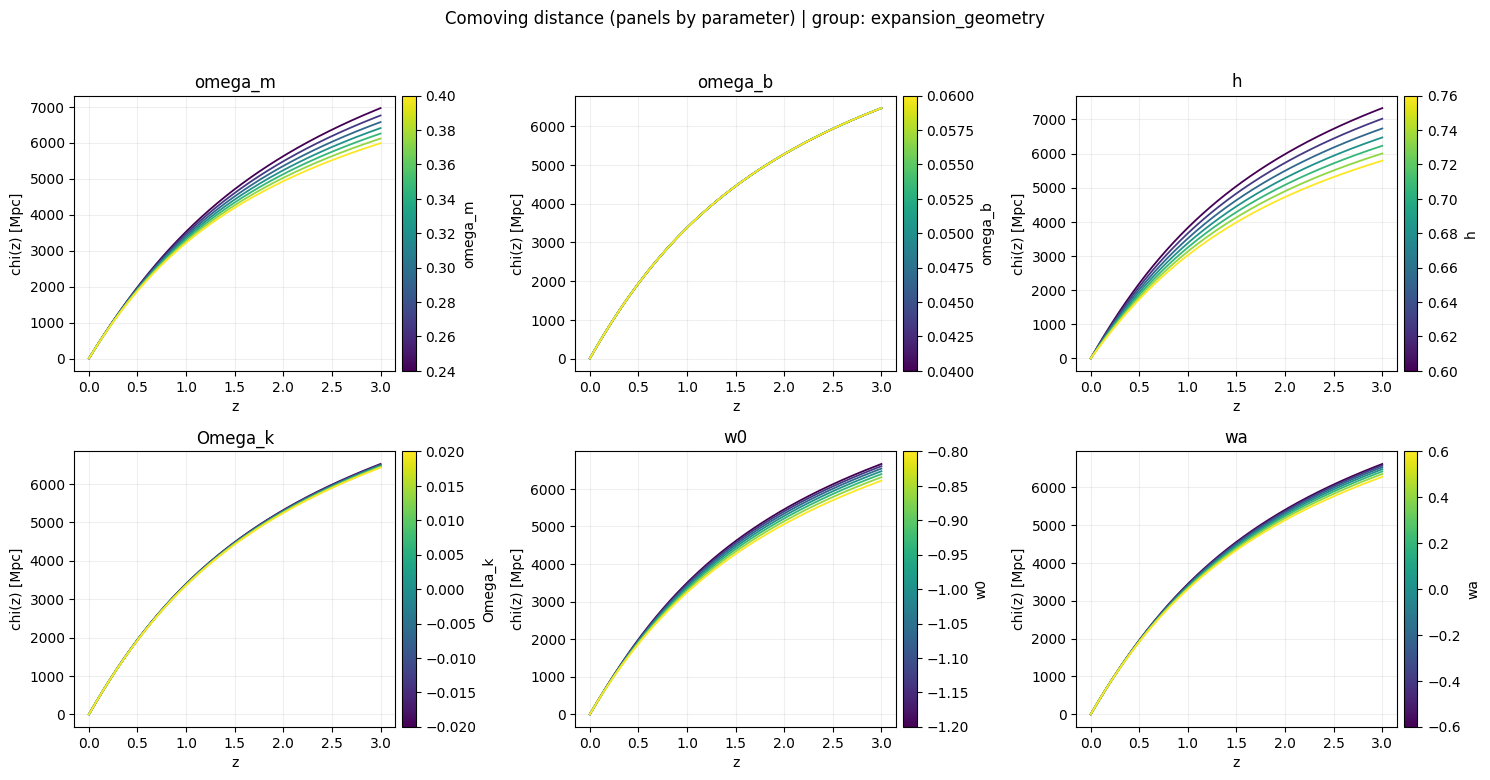

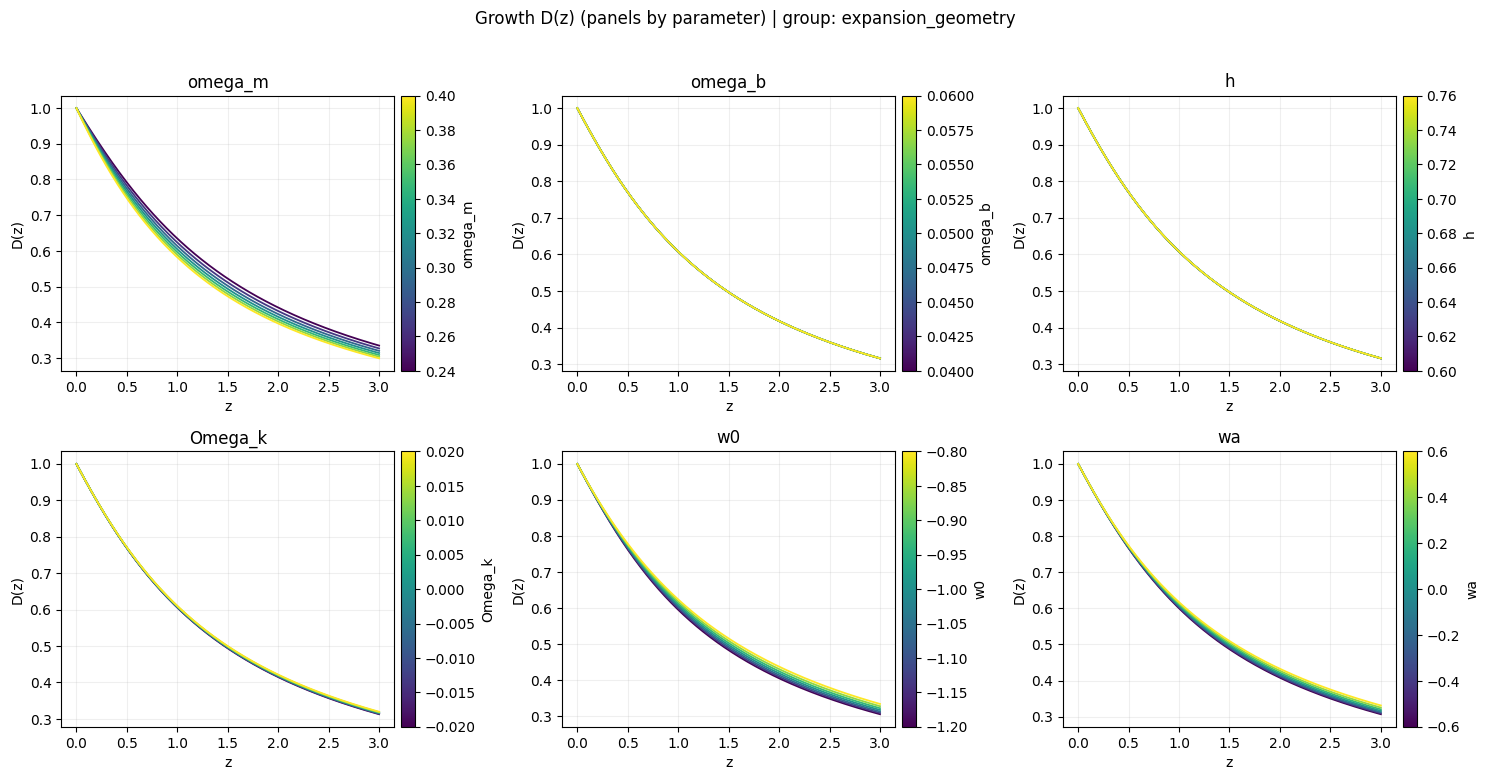

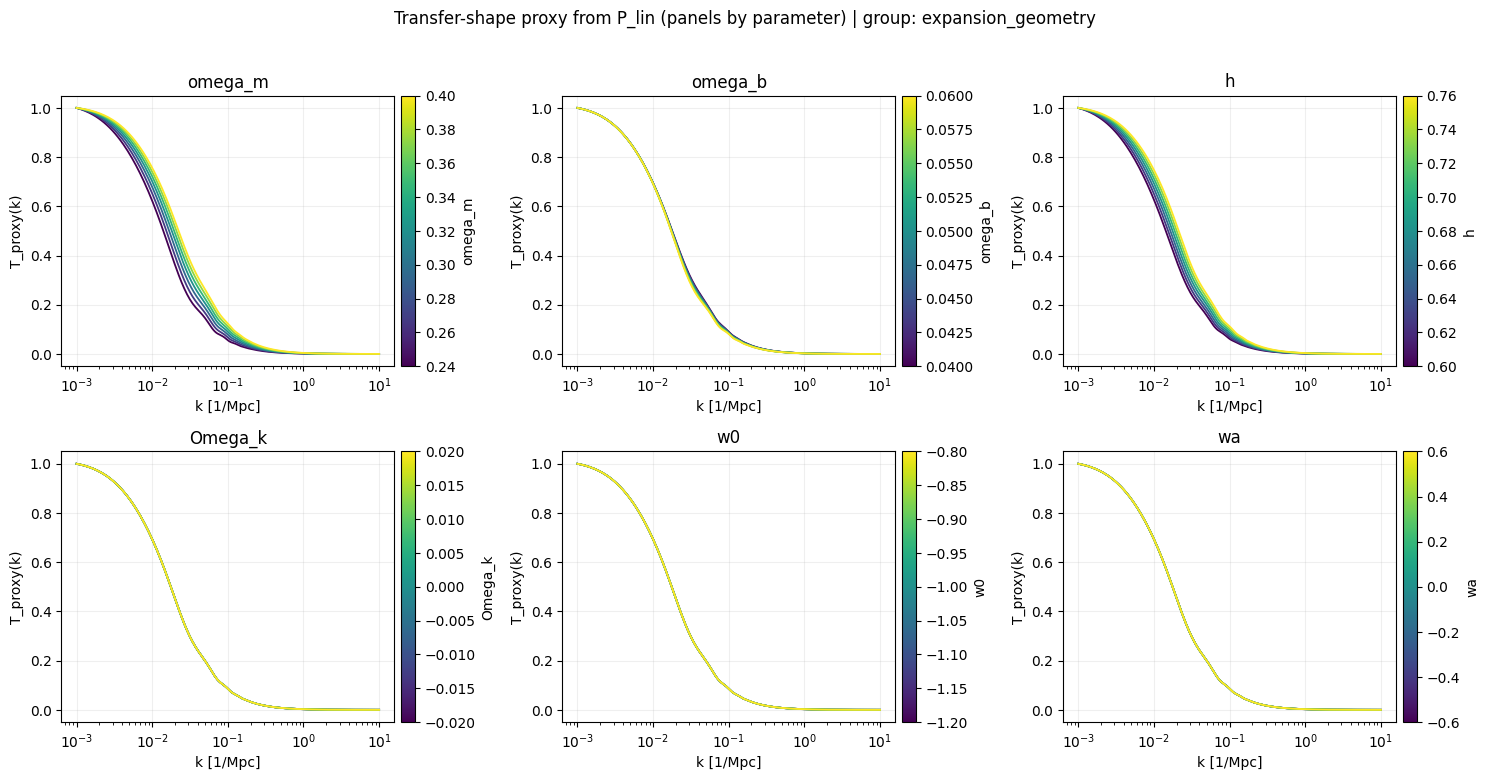

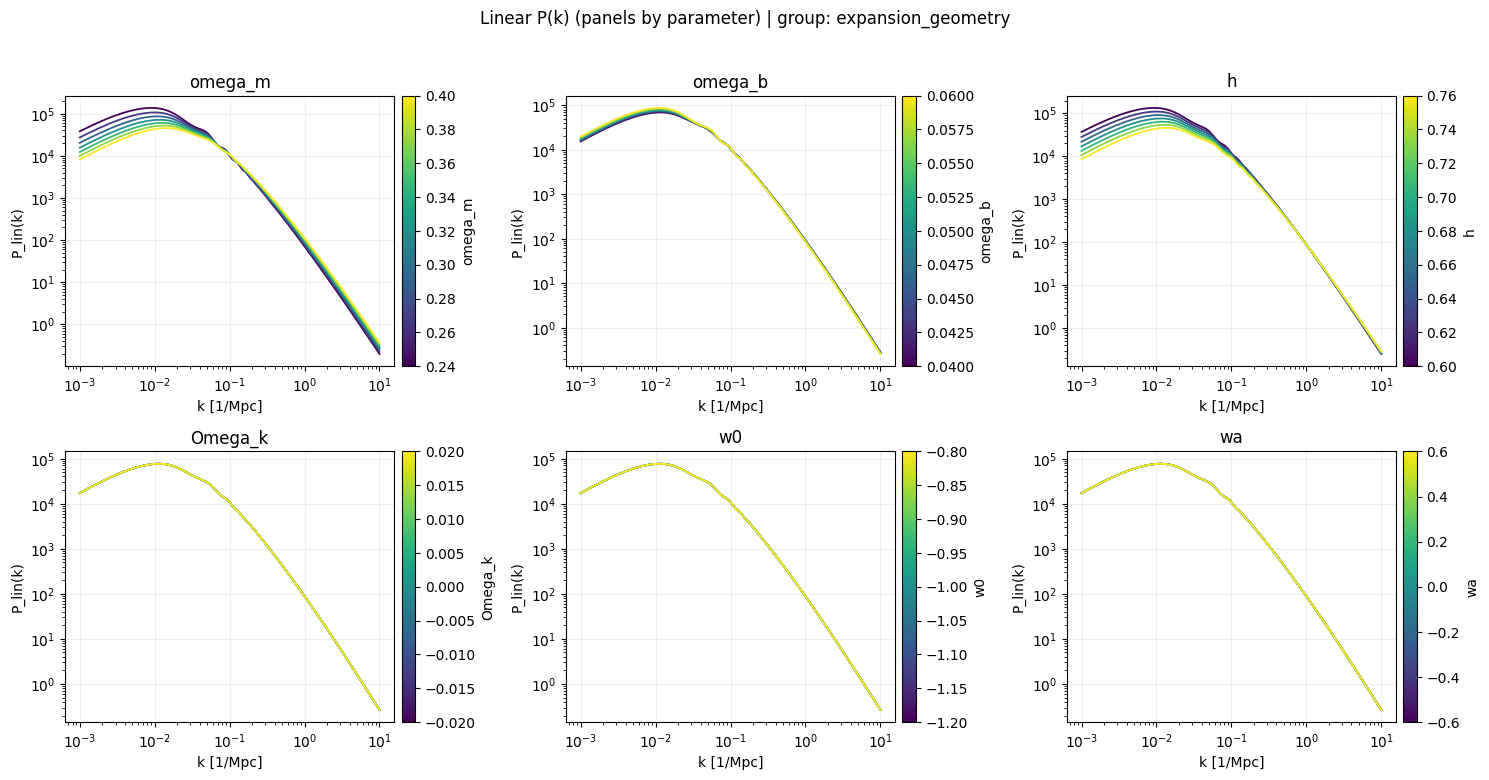

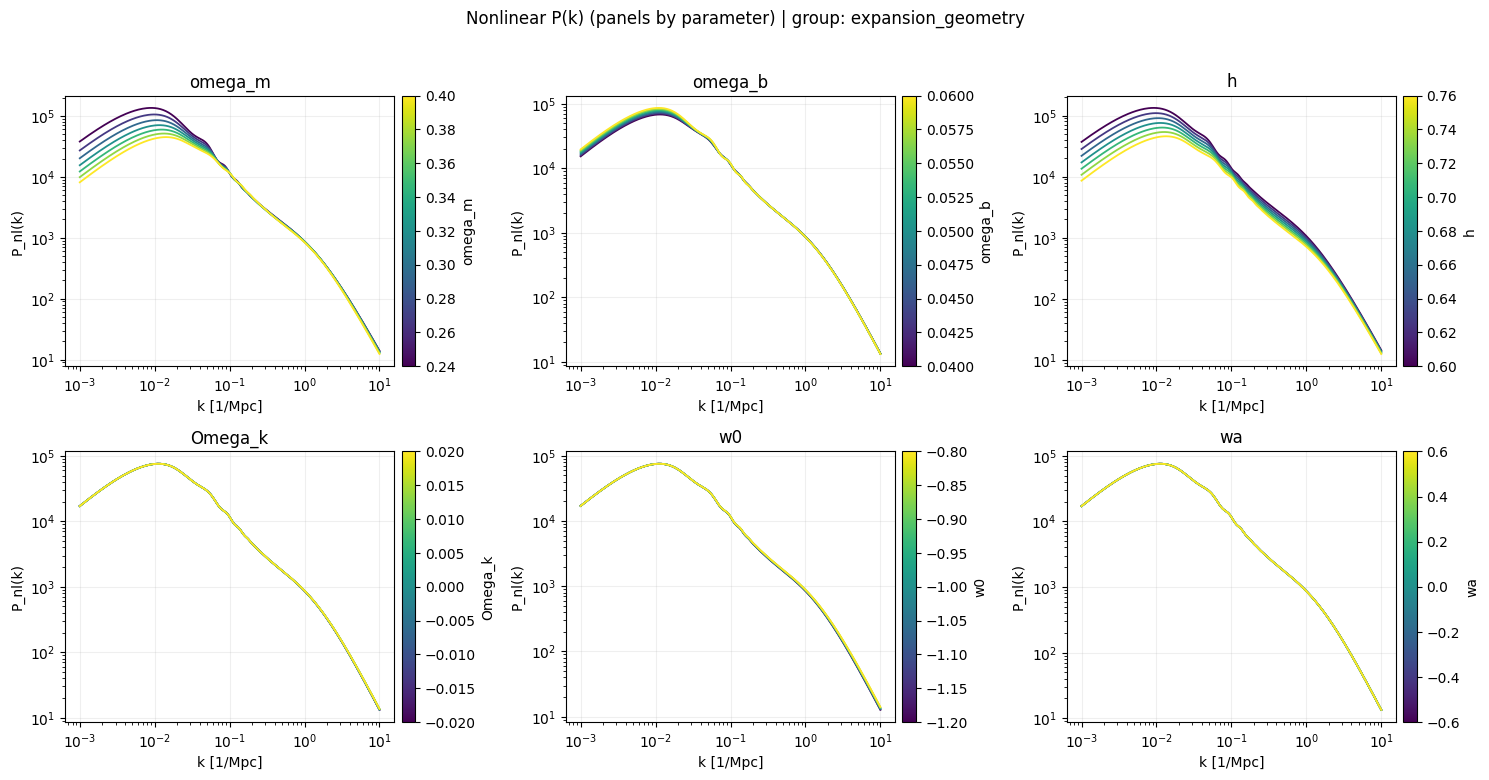

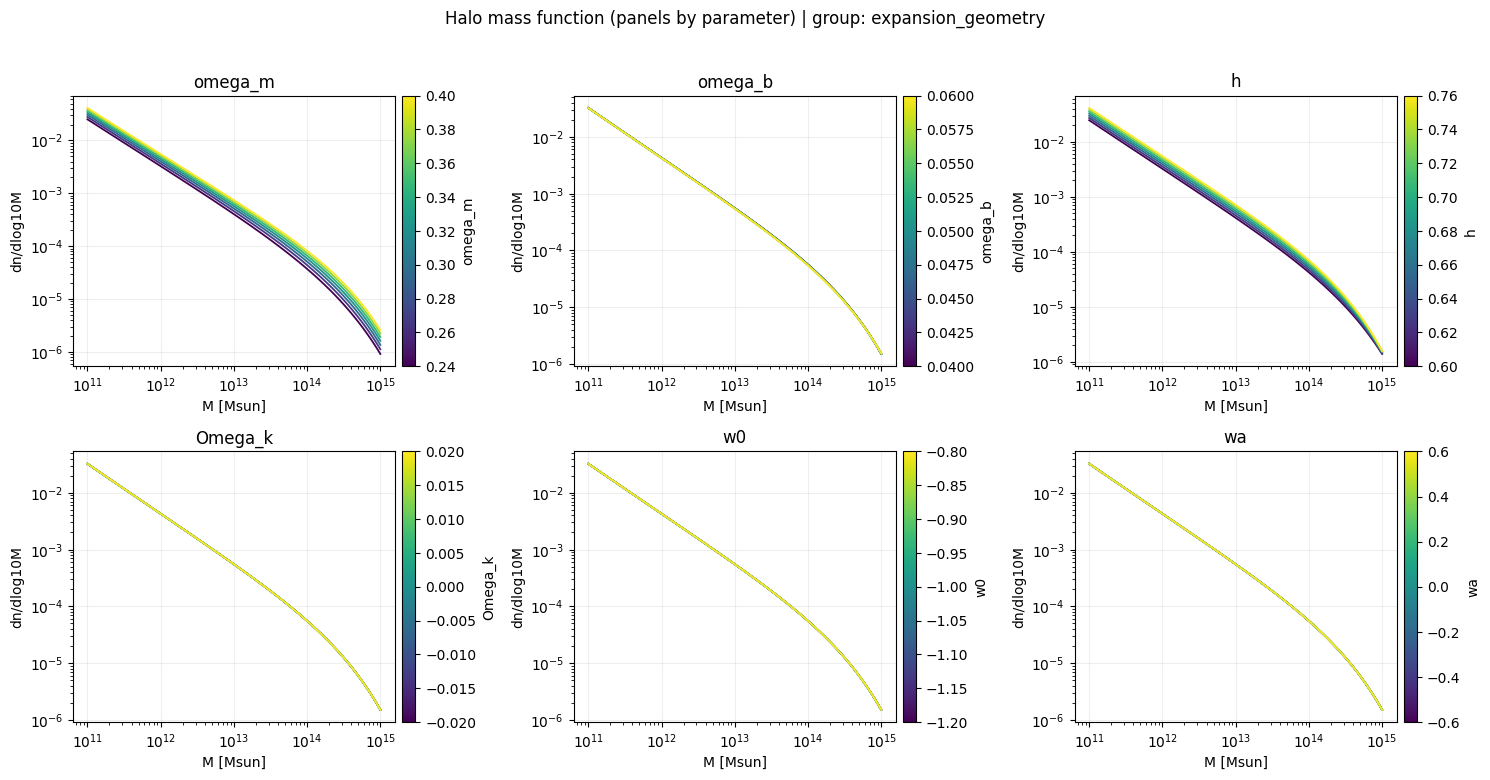

In [44]:
run_group('expansion_geometry')


## Group: `growth_primordial`



=== Group: growth_primordial (4 params) ===


[skip] m_nu=0.05: m_nu < 0.059226785828928465 incompatible with mass hierarchy


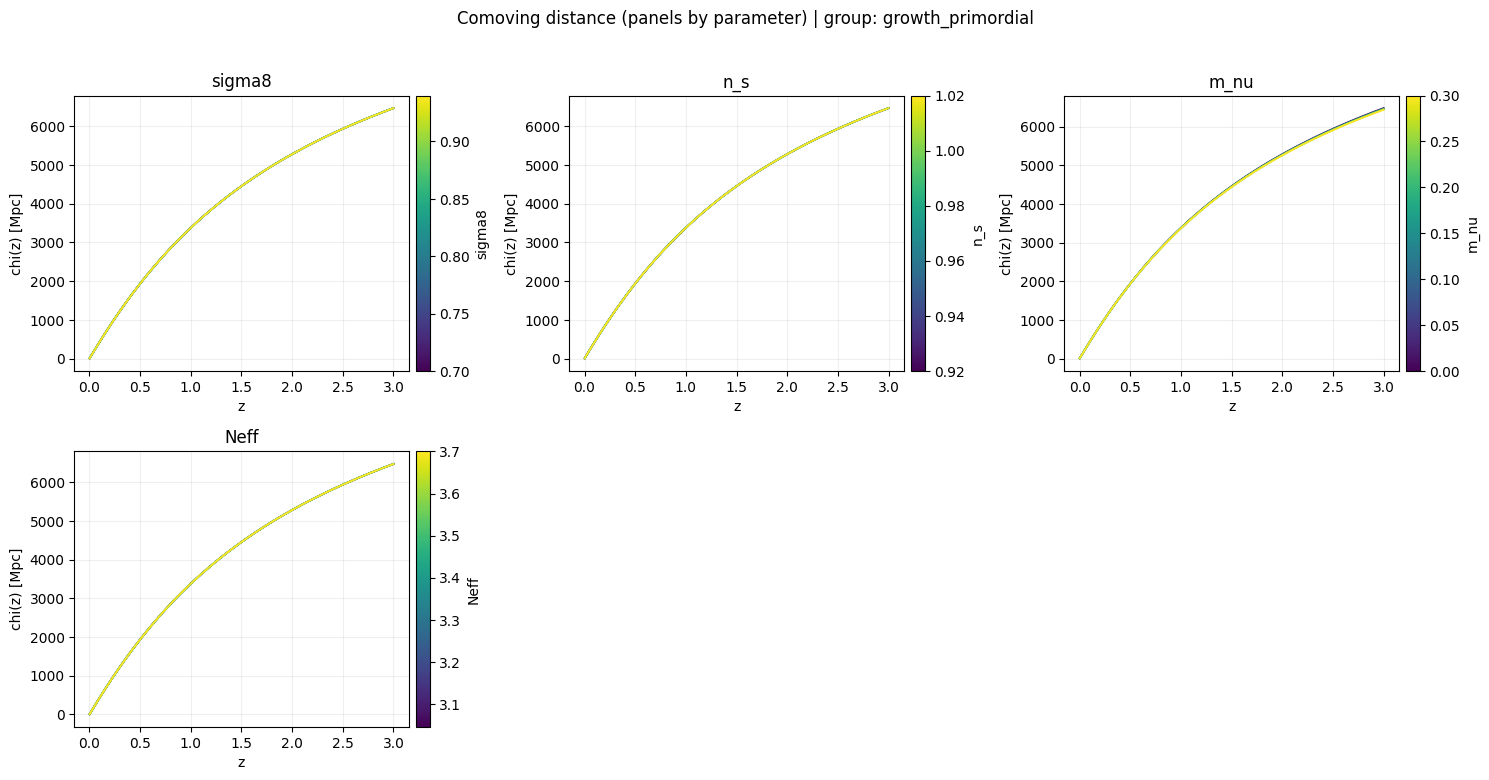

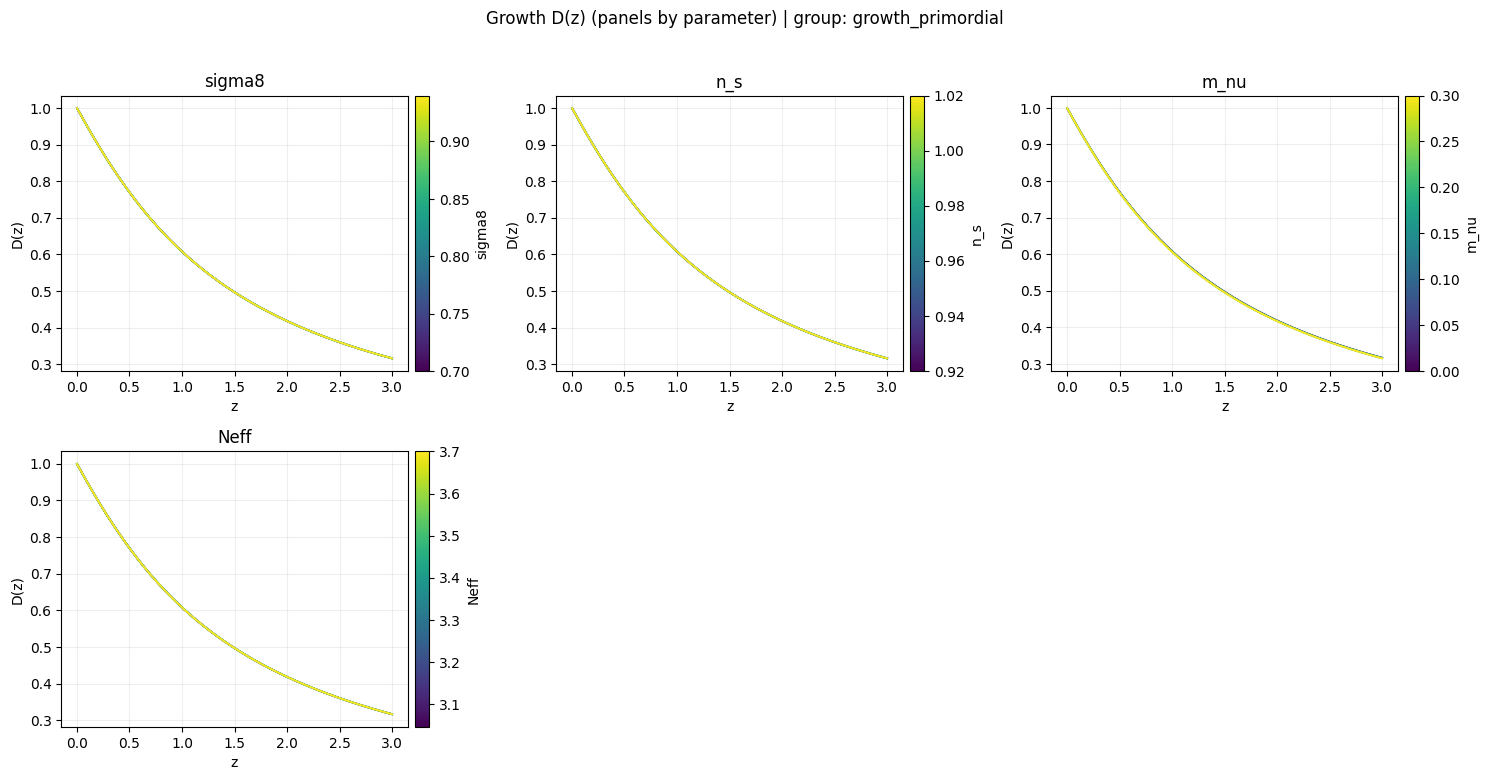

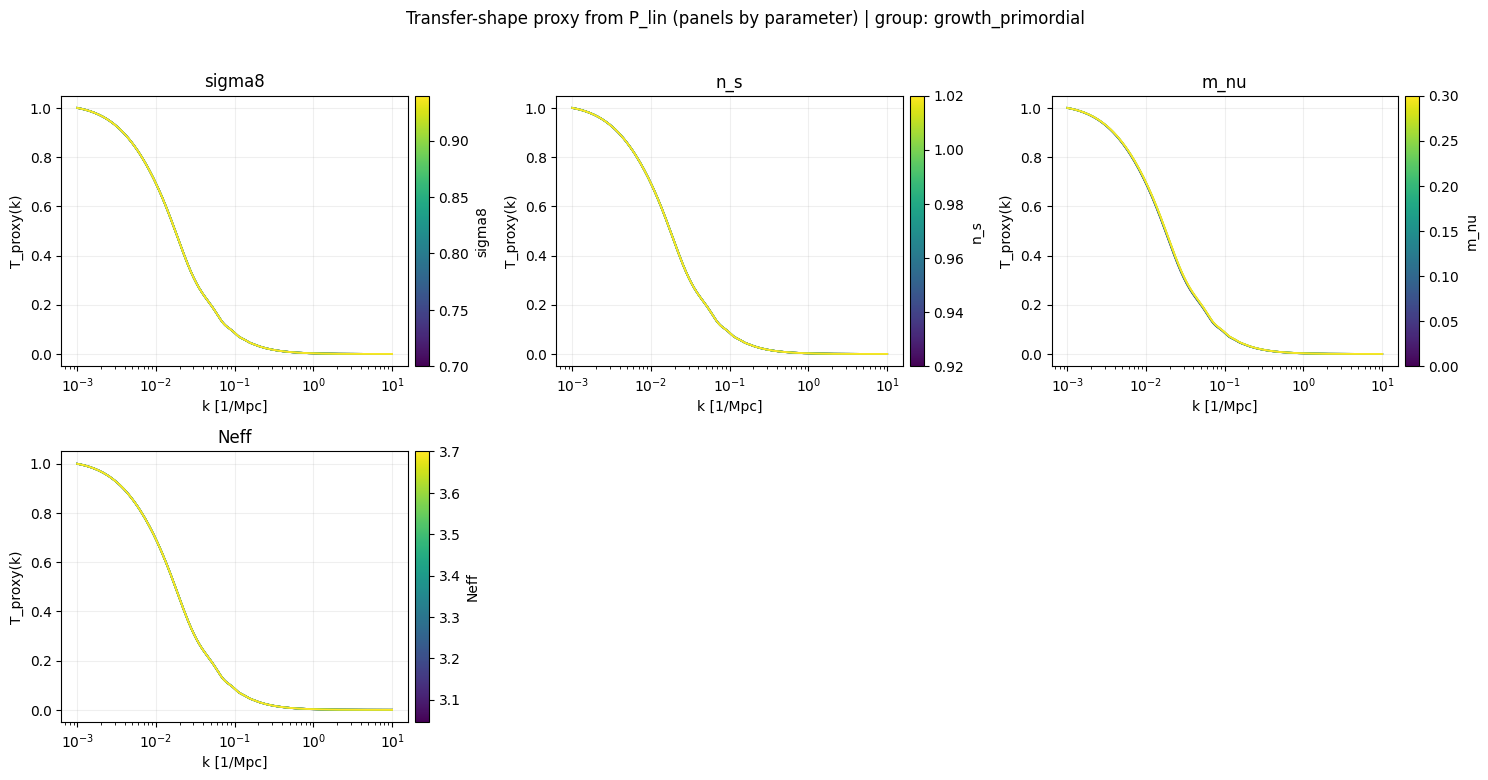

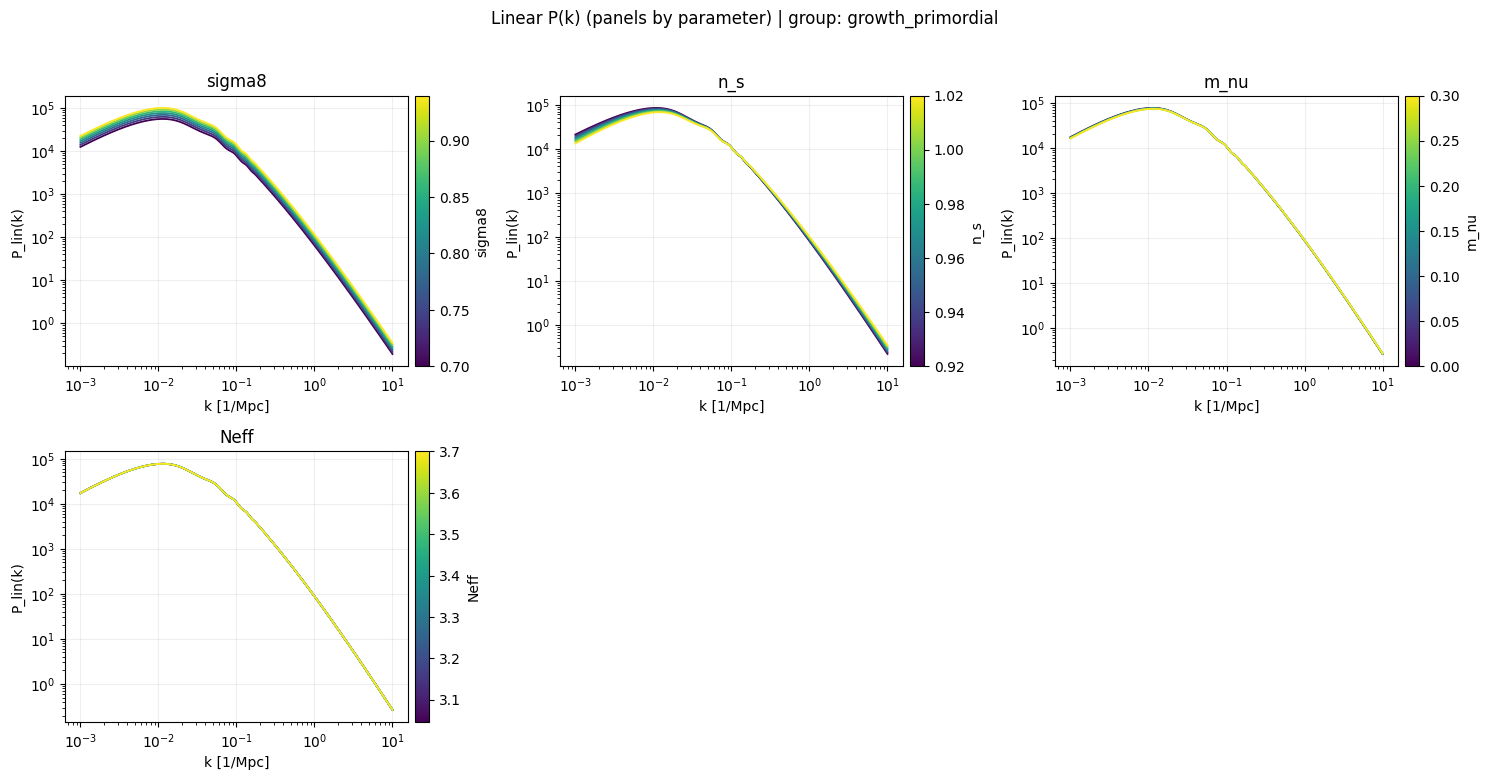

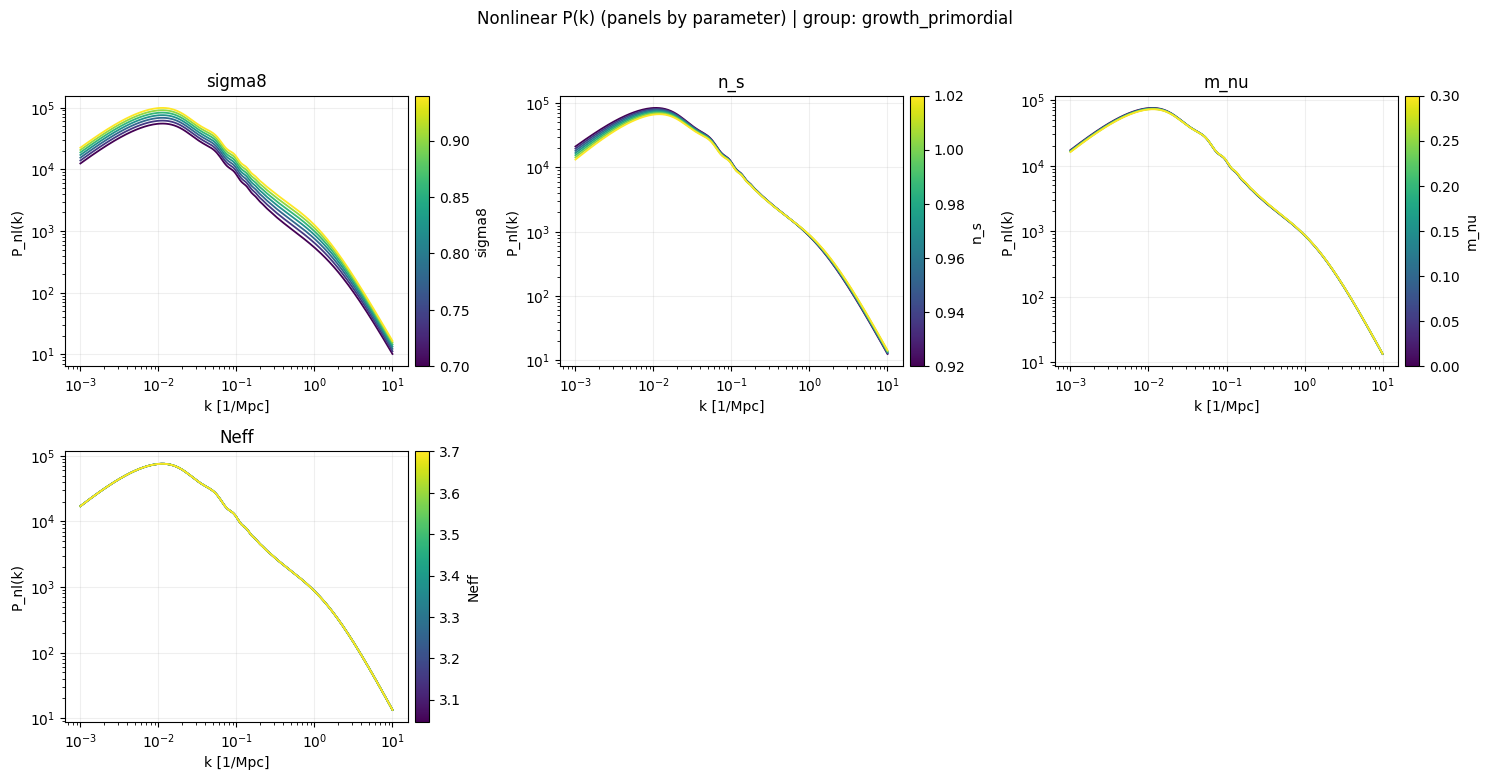

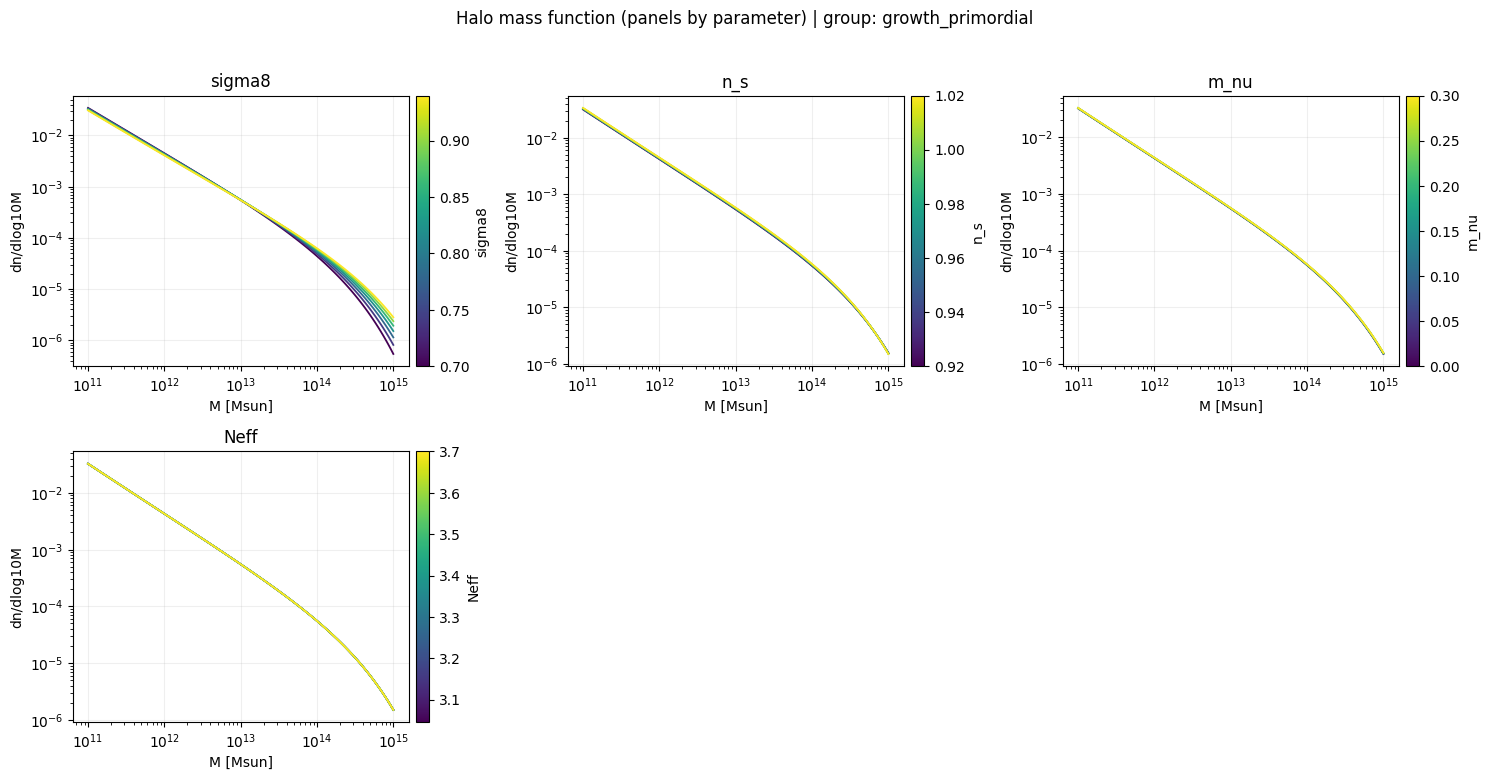

In [45]:
run_group('growth_primordial')
